# Chapter 4 exercise implementation
Much help from:
https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/04.%20Sample%20Weights.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj

## Code snippets

### Estimating uniqueness of a label [4.1]

In [2]:
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

In [161]:
# def mpNumCoEvents(closeIdx,t1,molecule):
#     '''
#     Compute the number of concurrent events per bar.
#     +molecule[0] is the date of the first event on which the weight will be computed
#     +molecule[-1] is the date of the last event on which the weight will be computed
    
#     Any event that starts before t1[modelcule].max() impacts the count.
#     '''
#     #1) find events that span the period [molecule[0],molecule[-1]]
#     t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
#     t1=t1[t1.index>=molecule[0]] # events that end at or after molecule[0]
#     t1=t1.loc[:t1.reindex(events.index).index[-1]] # events that start at or before t1[molecule].max()
#     #2) count events spanning a bar
#     iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.index[-1]]))
#     count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
#     for tIn,tOut in t1.iteritems(): 
#         #Basically, tIn and tOut is the range of a 'buy' to first touch of barrier, and for each of those ranges +1
#         count.loc[tIn:tOut]+=1.
#     return count.loc[molecule[0]:t1[molecule].max()]

### Estimating the average uniqueness of a label [4.2]

In [25]:
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule, dtype=float)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

### Build Indicator Matrix [4.3]

In [5]:
def getIndMatrix(barIx,t1):
    # Get Indicator matrix
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

### Compute average uniqueness [4.4]

In [6]:
def getAvgUniqueness(indM):
    # Average uniqueness from indicator matrix
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

### return sample from sequential bootstrap [4.5]

In [7]:
def seqBootstrap(indM,sLength=None):
    # Generate a sample via sequential bootstrap
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

### Determination of sample weight by absolute return attribution [4.10]¶

In [27]:
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule, dtype=float)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

### Implementation of Time-Decay Factors [4.11]

In [9]:
def getTimeDecay(tW,clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    print(const,slope)
    return clfW

### Example of Sequential Bootstrap [4.6]

In [11]:
def main():
    np.random.seed(12121) # fix seed as results are unstable
    t1=pd.Series([2,3,5],index=[0,2,4]) # t0,t1 for each feature obs
    barIx=range(t1.max()+1) # index of bars
    indM=snp.getIndMatrix(barIx,t1)
    phi_random=np.random.choice(indM.columns,size=indM.shape[1])
    print(phi_random)
    print(f'Standard uniqueness: {snp.getAvgUniqueness(indM[phi_random]).mean():.4f}')
    phi_seq=snp.seqBootstrap(indM)
    print(phi_seq)
    print(f'Sequential uniqueness: {snp.getAvgUniqueness(indM[phi_seq]).mean():.4f}')
    
# main()

# Exercise

## 1. In Chapter 3, we denoted as t1 a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the getEvents function.

### a) Compute a t1 series on dollar bars derived from E-mini S&P 500 futures tick data.
(Or in this case btc)

In [3]:
t1 = pd.to_datetime(pd.read_csv("../data/t1.csv", index_col=0, parse_dates=True, squeeze=True))

In [4]:
t1

2021-04-23 07:31:43.163   2021-04-24 07:31:46.976
2021-04-23 08:09:56.981   2021-04-24 08:10:03.818
2021-04-23 08:31:35.814   2021-04-24 08:31:40.279
2021-04-23 09:40:37.273   2021-04-24 09:40:40.242
2021-04-23 10:06:50.048   2021-04-24 10:06:52.614
                                    ...          
2021-06-18 03:49:00.094   2021-06-19 03:49:01.115
2021-06-18 10:02:30.206   2021-06-19 10:02:31.439
2021-06-18 10:57:56.538   2021-06-19 10:58:02.300
2021-06-18 13:13:03.131   2021-06-19 13:13:09.648
2021-06-18 14:16:19.376   2021-06-19 14:16:39.233
Name: time, Length: 594, dtype: datetime64[ns]

### b) Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time.

In [5]:
events = pd.read_csv("../data/events.csv", index_col=0, parse_dates=[0, 1])
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)

In [6]:
events

,t1,trgt,side
2021-04-23 07:31:43.163,2021-04-24 07:31:46.976,0.020325,NaN
2021-04-23 08:09:56.981,2021-04-24 08:10:03.818,0.020990,NaN
2021-04-23 08:31:35.814,2021-04-24 08:31:40.279,0.020496,NaN
2021-04-23 09:40:37.273,2021-04-24 09:40:40.242,0.019150,NaN
2021-04-23 10:06:50.048,2021-04-24 10:06:52.614,0.018793,NaN
...,...,...,...
2021-06-19 04:32:03.276,NaT,0.016546,NaN
2021-06-19 06:30:57.226,NaT,0.015636,NaN
2021-06-19 12:07:09.748,NaT,0.013532,NaN
2021-06-19 12:48:14.298,NaT,0.013560,NaN


In [12]:
# numCoEvents = mpNumCoEvents(closeIdx=df.index, t1=events.t1, molecule=events.index)
numCoEvents = mp_pandas_obj(mpNumCoEvents,('molecule',events.index),                         
                              1,closeIdx=df.index,t1=events['t1'])

In [9]:
numCoEvents

2021-04-23 07:31:43.163     1.0
2021-04-23 07:31:44.212     1.0
2021-04-23 07:31:45.347     1.0
2021-04-23 07:31:47.652     1.0
2021-04-23 07:31:50.047     1.0
                           ... 
2021-06-19 16:27:04.502    11.0
2021-06-19 16:27:20.667    11.0
2021-06-19 16:27:26.627    11.0
2021-06-19 16:27:44.405    11.0
2021-06-19 16:27:48.270    11.0
Length: 999315, dtype: float64

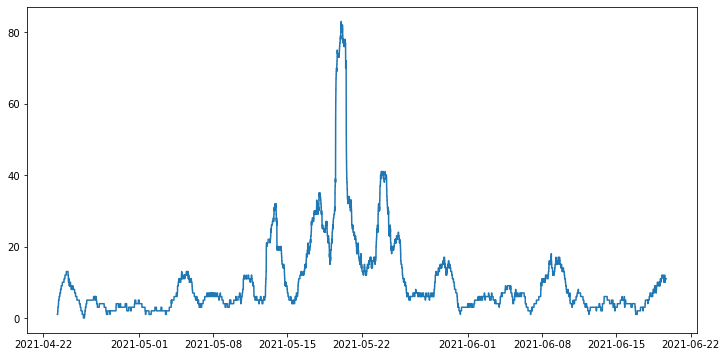

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(numCoEvents)

In [13]:
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]

In [14]:
numCoEvents = numCoEvents.reindex(df.index).fillna(0)

In [15]:
numCoEvents

time
2017-08-17 04:21:13.356     0.0
2017-08-17 04:29:19.766     0.0
2017-08-17 04:33:00.057     0.0
2017-08-17 04:39:32.027     0.0
2017-08-17 04:43:05.191     0.0
                           ... 
2021-06-19 16:27:04.502    11.0
2021-06-19 16:27:20.667    11.0
2021-06-19 16:27:26.627    11.0
2021-06-19 16:27:44.405    11.0
2021-06-19 16:27:48.270    11.0
Length: 11798850, dtype: float64

In [28]:
out=pd.DataFrame()
out['tW'] = mp_pandas_obj(mpSampleTW,('molecule',events.index),
                            1,t1=events['t1'],numCoEvents=numCoEvents)
## example ##
out['w']=mp_pandas_obj(mpSampleW,('molecule',events.index),1,
                         t1=events['t1'],numCoEvents=numCoEvents,close=df.close)
out['w']*=out.shape[0]/out['w'].sum()

out

,tW,w
2021-04-23 07:31:43.163,0.231878,1.226889
2021-04-23 08:09:56.981,0.156455,3.080714
2021-04-23 08:31:35.814,0.141238,1.225136
2021-04-23 09:40:37.273,0.122657,1.981628
2021-04-23 10:06:50.048,0.118390,0.726506
...,...,...
2021-06-19 04:32:03.276,0.089894,0.256731
2021-06-19 06:30:57.226,0.089685,0.136556
2021-06-19 12:07:09.748,0.090909,0.165209
2021-06-19 12:48:14.298,0.090909,0.078581
